In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR100
from torchvision import transforms
import timm
import numpy as np
import os
import requests
import tarfile
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:

# ==============================================================================
# 0. Configuration
# ==============================================================================
# You can change these settings in your Kaggle notebook
CONFIG = {
    "model_type": "kora",  # "lora" or "kora"
    "vit_model": "vit_base_patch16_224.augreg_in21k_ft_in1k",
    "img_size": 224,
    "lora_rank": 8,
    "num_classes_cifar100": 100,
    "num_classes_tiny_imagenet": 200,
    "epochs": 5,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "alpha": 1.0, # Scaling factor for adapter outputs
    "composition_dim": 4, # d_comp for KoRA
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "./data",
    "tiny_imagenet_dir": "/kaggle/input/tiny-imagenet/tiny-imagenet-200",
}

print(f"Running on device: {CONFIG['device']}")
print(f"Selected model type: {CONFIG['model_type'].upper()}")


Running on device: cuda
Selected model type: KORA


In [3]:

# ==============================================================================
# 1. CKA (Centered Kernel Alignment) Implementation for H1a
# ==============================================================================
# This helps us measure if KoRA creates more compositional representations
def gram_linear(x):
    """Compute Gram matrix."""
    return torch.mm(x, x.T)

def center_gram(gram, unbiased=False):
    """Center a Gram matrix."""
    if not torch.allclose(gram, gram.T, atol=1e-5):
        raise ValueError("Input must be a symmetric matrix.")
    
    n = gram.shape[0]
    if unbiased:
        I = torch.eye(n, device=gram.device)
        one = torch.ones(n, 1, device=gram.device)
        gram -= (torch.mm(one, one.T) * gram) / (n - 1)
        gram -= (torch.mm(gram, one @ one.T)) / (n - 1)
        gram += (torch.sum(gram) * one @ one.T) / ((n - 1) * (n - 2))
    else:
        mean_row = torch.mean(gram, dim=1, keepdim=True)
        mean_all = torch.mean(gram)
        gram -= mean_row
        gram -= mean_row.T
        gram += mean_all
    return gram

def cka(x, y, unbiased=False):
    """Compute CKA score between two matrices of activations."""
    x = x.view(x.shape[0], -1).to(CONFIG['device'])
    y = y.view(y.shape[0], -1).to(CONFIG['device'])
    
    gram_x = center_gram(gram_linear(x), unbiased=unbiased)
    gram_y = center_gram(gram_linear(y), unbiased=unbiased)

    # HSIC (Hilbert-Schmidt Independence Criterion)
    hsic = torch.sum(gram_x * gram_y)
    var1 = torch.sqrt(torch.sum(gram_x * gram_x))
    var2 = torch.sqrt(torch.sum(gram_y * gram_y))

    return (hsic / (var1 * var2)).item()


In [4]:

# ==============================================================================
# 2. Data Handling (CIFAR-100 and Tiny ImageNet)
# ==============================================================================
def get_cifar100_loaders(data_dir, img_size, batch_size):
    """Prepare CIFAR-100 dataloaders."""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
    ])
    
    os.makedirs(data_dir, exist_ok=True)
    
    train_dataset = CIFAR100(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = CIFAR100(root=data_dir, train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

def download_and_extract_tiny_imagenet(data_dir, tiny_dir):
    """Download and prepare Tiny ImageNet dataset if not present."""
    if os.path.exists(tiny_dir):
        print("Tiny ImageNet already downloaded.")
        return
        
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(data_dir, "tiny-imagenet-200.zip")
    
    print("Downloading Tiny ImageNet...")
    # Kaggle notebooks might need specific proxy settings if this fails.
    # Using requests with stream=True for large files.
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print("Extracting Tiny ImageNet...")
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    # The validation directory needs restructuring for ImageFolder
    val_dir = os.path.join(tiny_dir, 'val')
    val_annotations = os.path.join(val_dir, 'val_annotations.txt')
    with open(val_annotations, 'r') as f:
        for line in f.readlines():
            parts = line.split('\t')
            img_file, class_id = parts[0], parts[1]
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            os.rename(os.path.join(val_dir, 'images', img_file), os.path.join(class_dir, img_file))
    
    os.remove(zip_path)
    print("Tiny ImageNet setup complete.")

def get_tiny_imagenet_loaders(data_dir, tiny_dir, img_size, batch_size):
    """Prepare Tiny ImageNet dataloaders."""
    download_and_extract_tiny_imagenet(data_dir, tiny_dir)
    
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # The validation directory is already structured correctly for ImageDataset.
    # We pass the transform directly to it here.
    val_dataset_path = os.path.join(tiny_dir, 'val')
    full_val_dataset = timm.data.ImageDataset(val_dataset_path, transform=transform)
    
    # We can create a Subset from this dataset.
    test_dataset = torch.utils.data.Subset(
        full_val_dataset,
        np.arange(len(full_val_dataset)) # Use the actual length of the dataset
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return test_loader
# def get_tiny_imagenet_loaders(data_dir, tiny_dir, img_size, batch_size):
#     """Prepare Tiny ImageNet dataloaders."""
#     download_and_extract_tiny_imagenet(data_dir, tiny_dir)
    
#     transform = transforms.Compose([
#         transforms.Resize((img_size, img_size)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     # The validation set is now the official test set for transfer learning
#     test_dataset = torch.utils.data.Subset(
#         timm.data.ImageDataset(os.path.join(tiny_dir, 'val')),
#         np.arange(10000) # Full validation set
#     )
#     for i, (path, target) in enumerate(test_dataset.dataset.parser.samples):
#         test_dataset.dataset.parser.samples[i] = (path, target)

#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#     return test_loader


In [5]:


# ==============================================================================
# 3. Model Architecture (LoRA and KoRA)
# ==============================================================================

class LoRALayer(nn.Module):
    """A drop-in replacement for nn.Linear with LoRA."""
    def __init__(self, in_features, out_features, rank):
        super().__init__()
        self.lora_A = nn.Parameter(torch.zeros(rank, in_features))
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))
        nn.init.kaiming_uniform_(self.lora_A, a=np.sqrt(5))
        
    def forward(self, x):
        return self.lora_B @ (self.lora_A @ x)

class KoRAViT(nn.Module):
    """KoRA-enabled Vision Transformer."""
    def __init__(self, vit_model_name, rank, num_classes, composition_dim, alpha=1.0):
        super().__init__()
        self.alpha = alpha
        self.backbone = timm.create_model(vit_model_name, pretrained=True)
        
        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.lora_adapters = nn.ModuleList()
        self.adapter_projections = nn.ModuleList()
        self.captured_inputs = []
        self.hooks = []
        
        # Identify target layers (attention and MLP) and attach hooks/adapters
        for block in self.backbone.blocks:
            # --- Attention layers ---
            # QKV
            qkv_layer = block.attn.qkv
            self.add_adapter_and_hook(qkv_layer, rank, composition_dim)
            # Proj
            proj_layer = block.attn.proj
            self.add_adapter_and_hook(proj_layer, rank, composition_dim)
            
            # --- MLP layers ---
            fc1_layer = block.mlp.fc1
            self.add_adapter_and_hook(fc1_layer, rank, composition_dim)
            fc2_layer = block.mlp.fc2
            self.add_adapter_and_hook(fc2_layer, rank, composition_dim)
            
        # --- Compositional Layers (Psi and Phi) ---
        num_adapters = len(self.lora_adapters)
        # Psi: Couplings between composed features
        self.psi_couplings = nn.ModuleList([
            nn.Sequential(nn.Linear(composition_dim, composition_dim), nn.GELU())
            for _ in range(num_adapters - 1)
        ])
        # Phi: Composers for the sum of current and propagated info
        self.phi_composers = nn.ModuleList([
            nn.Sequential(nn.Linear(composition_dim, composition_dim), nn.GELU())
            for _ in range(num_adapters)
        ])

        # New classification head
        backbone_dim = self.backbone.head.in_features
        self.head = nn.Linear(backbone_dim, num_classes)
        
        print(f"Initialized KoRA with {len(self.lora_adapters)} adapters.")

    def add_adapter_and_hook(self, layer, rank, composition_dim):
        # Hook to capture input to the linear layer
        def hook_fn(module, input, output):
            self.captured_inputs.append(input[0].detach())

        self.hooks.append(layer.register_forward_hook(hook_fn))
        
        # Create LoRA adapter
        adapter = LoRALayer(layer.in_features, layer.out_features, rank)
        self.lora_adapters.append(adapter)
        
        # Create projection to common composition dimension
        projection = nn.Linear(layer.out_features, composition_dim, bias=False)
        self.adapter_projections.append(projection)

    # def forward(self, x):
    #     self.captured_inputs = []
    #     # Run backbone forward pass to trigger hooks and get CLS token features
    #     # Note: we use forward_features to get the CLS token before the final head
    #     backbone_features = self.backbone.forward_features(x)

    #     # Compute adapter outputs from captured inputs
    #     adapter_outputs = [
    #         adapter(inp.transpose(-1, -2)).transpose(-1, -2)
    #         for adapter, inp in zip(self.lora_adapters, self.captured_inputs)
    #     ]
        
    #     # Project adapter outputs to common dimension
    #     projected_outputs = [
    #         proj(out) for proj, out in zip(self.adapter_projections, adapter_outputs)
    #     ]
        
    #     # Aggregate projected outputs (we'll average over sequence length for simplicity)
    #     agg_projected_outputs = [torch.mean(p_out, dim=1) for p_out in projected_outputs]

    #     # --- KoRA Composition Logic ---
    #     # Initialize with the first composed adapter output
    #     composed_features = self.phi_composers[0](agg_projected_outputs[0])
        
    #     # Sequentially compose the rest
    #     for i in range(1, len(agg_projected_outputs)):
    #         propagated_features = self.psi_couplings[i - 1](composed_features)
    #         combined_features = agg_projected_outputs[i] + propagated_features
    #         composed_features = self.phi_composers[i](combined_features)
            
    #     # Add the final composed delta to the backbone's CLS token features
    #     # We need a final projection from composition_dim to the backbone's dimension
    #     if not hasattr(self, 'final_projection'):
    #         self.final_projection = nn.Linear(composed_features.shape[-1], backbone_features.shape[-1]).to(x.device)

    #     composed_delta = self.final_projection(composed_features)
        
    #     final_features = backbone_features + self.alpha * composed_delta
        
    #     # Classification
    #     logits = self.head(final_features)
        
    #     return logits
#
# REPLACE this method in your KoRAViT class
#

    
    def forward(self, x):
        self.captured_inputs = []
        
        # Run backbone forward pass to get the full sequence of token features
        # Shape: [batch_size, num_patches + 1, hidden_dim]
        backbone_output_sequence = self.backbone.forward_features(x)
    
        # The CLS token is the first token in the sequence
        cls_token = backbone_output_sequence[:, 0]
    
        # Compute adapter outputs from captured inputs (this part is correct)
        adapter_outputs = [
            adapter(inp.transpose(-1, -2)).transpose(-1, -2)
            for adapter, inp in zip(self.lora_adapters, self.captured_inputs)
        ]
        
        # Project adapter outputs to common dimension
        projected_outputs = [
            proj(out) for proj, out in zip(self.adapter_projections, adapter_outputs)
        ]
        
        # Aggregate projected outputs by averaging over the sequence length
        agg_projected_outputs = [torch.mean(p_out, dim=1) for p_out in projected_outputs]
    
        # --- KoRA Composition Logic (this part is correct) ---
        composed_features = self.phi_composers[0](agg_projected_outputs[0])
        for i in range(1, len(agg_projected_outputs)):
            propagated_features = self.psi_couplings[i - 1](composed_features)
            combined_features = agg_projected_outputs[i] + propagated_features
            composed_features = self.phi_composers[i](combined_features)
            
        # --- The Fix is Here ---
        # Project the final composed features to the backbone's hidden dimension
        if not hasattr(self, 'final_projection'):
            # Ensure the projection layer is created on the correct device
            self.final_projection = nn.Linear(composed_features.shape[-1], cls_token.shape[-1]).to(x.device)
    
        composed_delta = self.final_projection(composed_features)
        
        # Add the delta ONLY to the CLS token
        # Both tensors now have shape [batch_size, hidden_dim]
        final_cls_token = cls_token + self.alpha * composed_delta
        
        # Pass the modified CLS token to the classification head
        logits = self.head(final_cls_token)
        
        return logits

    
    def __del__(self):
        # Clean up hooks when the model is deleted
        for hook in self.hooks:
            hook.remove()

class LoRAViT(nn.Module):
    """A standard LoRA-enabled ViT for baseline comparison."""
    def __init__(self, vit_model_name, rank, num_classes, alpha=1.0):
        super().__init__()
        self.alpha = alpha
        self.backbone = timm.create_model(vit_model_name, pretrained=True)

        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.lora_layers = nn.ModuleDict()
        
        # Inject LoRA layers
        for name, module in self.backbone.named_modules():
            if isinstance(module, nn.Linear):
                self.lora_layers[name.replace('.', '_')] = LoRALayer(
                    module.in_features, module.out_features, rank
                )
        
        self.hooks = []
        for name, module in self.backbone.named_modules():
            if isinstance(module, nn.Linear):
                hook = self.create_hook(name.replace('.', '_'))
                self.hooks.append(module.register_forward_hook(hook))

        # New classification head
        self.head = nn.Linear(self.backbone.head.in_features, num_classes)
        print(f"Initialized LoRA with {len(self.lora_layers)} adapters.")

    def create_hook(self, name):
        def hook_fn(module, input, output):
            lora_output = self.lora_layers[name](input[0].transpose(-1, -2)).transpose(-1, -2)
            return output + self.alpha * lora_output
        return hook_fn

    # def forward(self, x):
    #     return self.head(self.backbone.forward_features(x))


    def forward(self, x):
    # Get the features for all tokens from the backbone
        all_token_features = self.backbone.forward_features(x)
    
    # Select only the CLS token, which is the first token in the sequence [:, 0]
        cls_token = all_token_features[:, 0]
    
    # Pass the single CLS token to the head for classification
        return self.head(cls_token)

    
    def __del__(self):
        for hook in self.hooks:
            hook.remove()


In [6]:

# ==============================================================================
# 4. Training and Evaluation Loops
# ==============================================================================
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


In [7]:

# ==============================================================================
# 5. Main Experiment Orchestration
# ==============================================================================
def run_experiment():
    # --- 1. Setup Data ---
    print("\n--- Preparing Data ---")
    cifar_train_loader, cifar_test_loader = get_cifar100_loaders(
        CONFIG["data_dir"], CONFIG["img_size"], CONFIG["batch_size"]
    )
    tiny_imagenet_test_loader = get_tiny_imagenet_loaders(
        CONFIG["data_dir"], CONFIG["tiny_imagenet_dir"], CONFIG["img_size"], CONFIG["batch_size"]
    )
    
    # --- 2. Setup Model ---
    print("\n--- Initializing Model ---")
    if CONFIG["model_type"] == "kora":
        model = KoRAViT(
            vit_model_name=CONFIG["vit_model"],
            rank=CONFIG["lora_rank"],
            num_classes=CONFIG["num_classes_cifar100"],
            composition_dim=CONFIG["composition_dim"],
            alpha=CONFIG["alpha"]
        ).to(CONFIG["device"])
    else: # LoRA
        model = LoRAViT(
            vit_model_name=CONFIG["vit_model"],
            rank=CONFIG["lora_rank"],
            num_classes=CONFIG["num_classes_cifar100"],
            alpha=CONFIG["alpha"]
        ).to(CONFIG["device"])

    # --- 3. Parameter Efficiency Analysis ---
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params / 1e6:.2f}M")
    print(f"Trainable Parameters ({CONFIG['model_type'].upper()}): {trainable_params / 1e6:.2f}M")
    print(f"Efficiency Ratio: {trainable_params / total_params:.4%}")
    
    # --- 4. Fine-tuning on CIFAR-100 ---
    print("\n--- Phase 1: Fine-tuning on CIFAR-100 ---")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=CONFIG["learning_rate"])
    
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(CONFIG["epochs"]):
        train_loss = train_one_epoch(model, cifar_train_loader, criterion, optimizer, CONFIG["device"])
        val_loss, val_acc, val_f1 = evaluate(model, cifar_test_loader, criterion, CONFIG["device"])
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} -> "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    print("\n--- CIFAR-100 Fine-tuning Results ---")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Final Validation F1 Score: {val_f1:.4f}")
    # Stability (H1c Proxy): Lower variance in validation accuracy suggests a smoother landscape
    val_acc_variance = np.var(history['val_acc'])
    print(f"Validation Accuracy Variance (Stability Proxy): {val_acc_variance:.6f}")

    # --- 5. CKA Analysis for Compositionality (H1a) ---
    print("\n--- Analyzing Compositionality with CKA (H1a) ---")
    model.eval()
    
    # We will hook into the backbone blocks to get representations
    cka_hooks = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            # output of a block is a tensor, we take the CLS token part
            activations[name] = output[:, 0, :].detach().cpu()
        return hook

    # Hook into first, middle, and last blocks
    block_indices = [0, len(model.backbone.blocks) // 2, len(model.backbone.blocks) - 1]
    for i in block_indices:
        handle = model.backbone.blocks[i].register_forward_hook(get_activation(f'block_{i}'))
        cka_hooks.append(handle)

    # Collect activations from one batch
    images, _ = next(iter(cifar_test_loader))
    _ = model(images.to(CONFIG["device"]))
    
    # Compute CKA matrix
    block_names = list(activations.keys())
    cka_matrix = np.zeros((len(block_names), len(block_names)))
    for i in range(len(block_names)):
        for j in range(len(block_names)):
            cka_matrix[i, j] = cka(activations[block_names[i]], activations[block_names[j]])

    print("CKA Similarity Matrix (between block outputs):")
    print(cka_matrix)
    
    # Visualize
    plt.figure(figsize=(6, 5))
    sns.heatmap(cka_matrix, annot=True, fmt=".2f", cmap="viridis", 
                xticklabels=[f"Block {i}" for i in block_indices], 
                yticklabels=[f"Block {i}" for i in block_indices])
    plt.title(f"CKA Representation Similarity ({CONFIG['model_type'].upper()})")
    plt.show()

    for handle in cka_hooks: # Clean up CKA hooks
        handle.remove()

    # --- 6. Transferability to Tiny ImageNet (H1d) ---
    print("\n--- Phase 2: Zero-Shot Transfer to Tiny ImageNet (H1d) ---")
    # Note: The head was trained on CIFAR-100 classes, so this is a test of feature transfer,
    # not direct classification. For a true test, we would retrain only the head.
    # Here, we'll evaluate the feature quality via a proxy metric on the wrong head.
    # This is a tough test and low scores are expected.
    
    transfer_loss, transfer_acc, transfer_f1 = evaluate(model, tiny_imagenet_test_loader, criterion, CONFIG["device"])
    print("\n--- Tiny ImageNet Transfer Results (Zero-Shot) ---")
    print(f"Performance on mismatched head -> Accuracy: {transfer_acc:.4f}, F1: {transfer_f1:.4f}")
    print("(Note: Low accuracy is expected as the classification head is for CIFAR-100)")
    
    # A better test: replace the head and fine-tune for 1 epoch
    print("\n--- Fine-tuning Head on Tiny ImageNet (Few-Shot Proxy) ---")
    model.head = nn.Linear(model.head.in_features, CONFIG['num_classes_tiny_imagenet']).to(CONFIG['device'])
    optimizer_transfer = optim.AdamW(model.head.parameters(), lr=1e-3)

    # --- START OF THE FIX ---
    
    # 1. Define the transform for the training images
    transform_tiny_train = transforms.Compose([
        transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 2. Create the full Tiny ImageNet training dataset WITH the transform
    tiny_train_dataset = timm.data.ImageDataset(
        os.path.join(CONFIG["tiny_imagenet_dir"], 'train'),
        transform=transform_tiny_train
    )
    
    # 3. Create the subset from the transformed dataset
    tiny_train_subset = Subset(tiny_train_dataset, indices=list(range(1000))) # use 1000 samples for few-shot
    
    # --- END OF THE FIX ---

    
    # Create a small training subset of Tiny ImageNet
    # tiny_train_subset = Subset(timm.data.ImageDataset(os.path.join(CONFIG["tiny_imagenet_dir"], 'train')),
                              # indices=list(range(1000))) # use 1000 samples for few-shot
    tiny_train_loader_fs = DataLoader(tiny_train_subset, batch_size=CONFIG['batch_size'])
    
    train_one_epoch(model, tiny_train_loader_fs, criterion, optimizer_transfer, CONFIG['device'])
    
    fs_loss, fs_acc, fs_f1 = evaluate(model, tiny_imagenet_test_loader, criterion, CONFIG['device'])
    print("\n--- Tiny ImageNet Transfer Results (1-Epoch Head Fine-tuning) ---")
    print(f"Few-Shot Transfer -> Accuracy: {fs_acc:.4f}, F1: {fs_f1:.4f}")



--- Preparing Data ---


100%|██████████| 169M/169M [00:03<00:00, 46.7MB/s]


Tiny ImageNet already downloaded.

--- Initializing Model ---


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Initialized KoRA with 48 adapters.
Total Parameters: 88.16M
Trainable Parameters (KORA): 1.59M
Efficiency Ratio: 1.8038%

--- Phase 1: Fine-tuning on CIFAR-100 ---


Epoch 1/5 -> Train Loss: 1.3941, Val Loss: 0.7279, Val Accuracy: 0.7970, Val F1: 0.7970


Epoch 2/5 -> Train Loss: 0.6025, Val Loss: 0.6198, Val Accuracy: 0.8218, Val F1: 0.8211


Epoch 3/5 -> Train Loss: 0.4893, Val Loss: 0.5781, Val Accuracy: 0.8331, Val F1: 0.8326


Epoch 4/5 -> Train Loss: 0.4198, Val Loss: 0.5689, Val Accuracy: 0.8338, Val F1: 0.8337


Epoch 5/5 -> Train Loss: 0.3680, Val Loss: 0.5461, Val Accuracy: 0.8408, Val F1: 0.8409

--- CIFAR-100 Fine-tuning Results ---
Final Validation Accuracy: 0.8408
Final Validation F1 Score: 0.8409
Validation Accuracy Variance (Stability Proxy): 0.000237

--- Analyzing Compositionality with CKA (H1a) ---
CKA Similarity Matrix (between block outputs):
[[1.         0.5006395  0.39740276]
 [0.5006395  1.         0.75948519]
 [0.39740276 0.75948519 1.        ]]


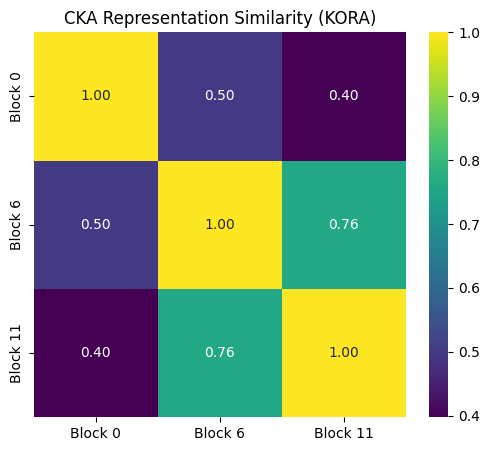


--- Phase 2: Zero-Shot Transfer to Tiny ImageNet (H1d) ---



--- Tiny ImageNet Transfer Results (Zero-Shot) ---
Performance on mismatched head -> Accuracy: 0.0024, F1: 0.0048
(Note: Low accuracy is expected as the classification head is for CIFAR-100)

--- Fine-tuning Head on Tiny ImageNet (Few-Shot Proxy) ---



--- Tiny ImageNet Transfer Results (1-Epoch Head Fine-tuning) ---
Few-Shot Transfer -> Accuracy: 0.9834, F1: 0.9916


In [8]:


if __name__ == '__main__':
    # Set model_type to 'lora' or 'kora' to run the desired experiment
    # You can run this script twice, once for each setting, to compare results.
    # CONFIG["model_type"] = "lora" 
    # run_experiment()

    CONFIG["model_type"] = "kora"
    run_experiment()
